In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import datetime
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [38]:
def load_exog_petroleum_database_week():
  petroleo = pd.read_csv('Petróleo Brent Futuros Dados Históricos.csv')
  petroleo['Data'] = pd.to_datetime(petroleo['Data'], format='%d.%m.%Y')
  petroleo = petroleo.sort_values(by='Data')
  petroleo['Último'] = petroleo['Último'].str.replace(',', '.').astype(float)
  return (petroleo['Último'])

In [34]:
def load_exog_covid_week(date_range): 
  start_covid = datetime.datetime(2020, 3, 1)
  covid_dummy = []
  for date in date_range: 
    if(start_covid < date):
      covid_dummy.append(1)
    else:
      covid_dummy.append(0)
  return (covid_dummy)

In [2]:
def load_database_mounth(): 
  filename = 'mensal-regioes-desde-jan2013.xlsx'
  #file_url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-regioes-desde-2013.xlsx"
  database = pd.read_excel(filename, skiprows=16)
  ## Excluir colunas desnecessárias
  database = database.drop([
    'NÚMERO DE POSTOS PESQUISADOS', 
    'UNIDADE DE MEDIDA',
    'DESVIO PADRÃO REVENDA',
    'PREÇO MÍNIMO REVENDA',
    'PREÇO MÁXIMO REVENDA',
    'MARGEM MÉDIA REVENDA',
    'COEF DE VARIAÇÃO REVENDA',
    'PREÇO MÉDIO DISTRIBUIÇÃO',
    'DESVIO PADRÃO DISTRIBUIÇÃO',
    'PREÇO MÍNIMO DISTRIBUIÇÃO',
    'PREÇO MÁXIMO DISTRIBUIÇÃO',
    'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],
    axis=1
  )
  ## Renomear colunas
  database = database.rename(columns={
      'MÊS': 'date',
      'REGIÃO': 'region',
      'PRODUTO': 'product',
      'PREÇO MÉDIO REVENDA': 'price'
  })

  return(database)

def load_database_week(): 
  filename = 'semanal-regioes-desde-2013.xlsx'
  #file_url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-regioes-desde-2013.xlsx"
  database = pd.read_excel(filename, skiprows=17)
  ## Excluir colunas desnecessárias
  database = database.drop([
    'DATA FINAL',
    'NÚMERO DE POSTOS PESQUISADOS', 
    'UNIDADE DE MEDIDA',
    'DESVIO PADRÃO REVENDA',
    'PREÇO MÍNIMO REVENDA',
    'PREÇO MÁXIMO REVENDA',
    'MARGEM MÉDIA REVENDA',
    'COEF DE VARIAÇÃO REVENDA',
    'PREÇO MÉDIO DISTRIBUIÇÃO',
    'DESVIO PADRÃO DISTRIBUIÇÃO',
    'PREÇO MÍNIMO DISTRIBUIÇÃO',
    'PREÇO MÁXIMO DISTRIBUIÇÃO',
    'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],
    axis=1
  )
  ## Renomear colunas
  database = database.rename(columns={
      'DATA INICIAL': 'date',
      'REGIÃO': 'region',
      'PRODUTO': 'product',
      'PREÇO MÉDIO REVENDA': 'price'
  })

  return(database)


def load_database(freq): 
  if(freq == 'W'):
    return load_database_week()
  if(freq == 'M'):
    return load_database_mounth()

In [10]:
def create_date_range(start_date, end_date, freq): 
  return pd.date_range(
    start = start_date,
    end = end_date,
    freq= freq
  )

  

def create_time_series(data_frame, start_date, end_date, var, freq):
  # time series
  time_series = pd.Series(
      data = data_frame[var].values,
      index = pd.date_range(start = start_date, end = end_date, freq = freq)
    )

  return(time_series)


##  Converter o dataframe em uma serie temporal
def case_treatment(data, freq): 
  freqChoosed = pd.offsets.Week(1)
  freqSymbol = "W"

  if(freq == "M"):
    freqChoosed = pd.offsets.WeekOfMonth(1)
    freqSymbol = 'M'

  start_date = data['date'].min()
  end_date = data['date'].max()  
  date_range = create_date_range(
    start_date = start_date + freqChoosed, 
    end_date = end_date + freqChoosed, 
    freq=freqSymbol
  ) - freqChoosed
  
  data_aux = pd.DataFrame({'date': date_range })

  data = pd.merge(data_aux, data, on='date', how='left')

  data = data.set_index(["date"], drop=True)  
  data.interpolate(method='linear', inplace=True)

  time_series = create_time_series(
    data, 
    start_date, 
    end_date, 
    var="price", 
    freq=freqChoosed
  )
  return time_series

In [6]:
##  Separar por regiões e cada tipo de gasolina dentro de um dicionario. 
#   Exemplo de acesso a serie db['NORTE']['GASOLINA COMUM'];
def handler_database(database, freq): 
  db = {}
  for region in database['region'].unique():
    db[region] = {}
    for product in database['product'].unique():
      aux = database[(database['region'] == region) & (database['product'] == product)]
      aux = aux.filter(['date', 'price'])
      db[region][product] = case_treatment(data=aux, freq=freq)
  return (db)

In [31]:
##  Filtrar dados de interesse
freq = 'W'
database = load_database(freq=freq)
database = database[
  (database['product'] == "ETANOL HIDRATADO") | 
  (database['product'] == "GASOLINA COMUM") 
  # (database['product'] == "OLEO DIESEL") | 
  # (database['product'] == "OLEO DIESEL S10")
]

database.head(3)

,date,region,product,price
0,2012-12-30,CENTRO OESTE,ETANOL HIDRATADO,1.962
1,2012-12-30,NORDESTE,ETANOL HIDRATADO,2.191
2,2012-12-30,NORTE,ETANOL HIDRATADO,2.314


In [11]:
stack_database = handler_database(database, freq=freq)

In [12]:
data = stack_database["CENTRO OESTE"]['GASOLINA COMUM']
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 488 entries, 2012-12-30 to 2022-05-01
Freq: W
Series name: None
Non-Null Count  Dtype  
--------------  -----  
488 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


In [42]:
start_date = data.index.min()
end_date = data.index.max()

exog_covid = load_exog_covid_week(create_date_range(start_date=start_date, end_date=end_date, freq=freq))
# exog_petroleum = load_exog_petroleum_database_week()


In [13]:
from pmdarima.model_selection import train_test_split

# Tamanho da amostra de testes
test_size = 36
train_set, test_set = train_test_split(data, test_size=test_size)

In [14]:
from statsmodels.tsa.stattools import adfuller

fuller_test = adfuller(train_set)
fuller_test

(0.6937114451275089,
 0.9897115315927795,
 2,
 449,
 {'1%': -3.4449982835447894,
  '5%': -2.8679986379826814,
  '10%': -2.5702102140862397},
 -1364.6441732913236)

pValue (0.9897115315927795) > 0.01, - aceita-se H0
portanto a série NÃO é estacionária

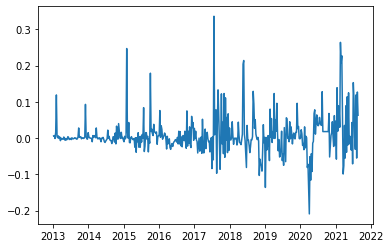

In [33]:
data_diff = train_set.diff(periods=1)
data_diff.drop(index=data_diff.index[0], axis=0, inplace=True)
plt.plot(data_diff)
plt.show()

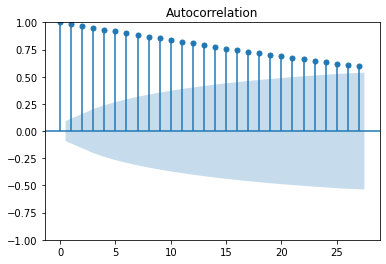

In [34]:
plot_acf(train_set)
plt.show()

c:\Users\Gabriel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


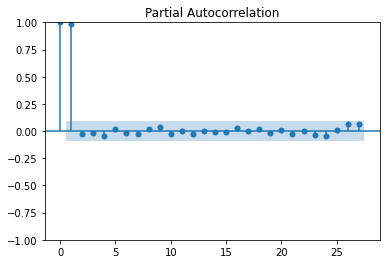

In [35]:
plot_pacf(train_set)
plt.show()

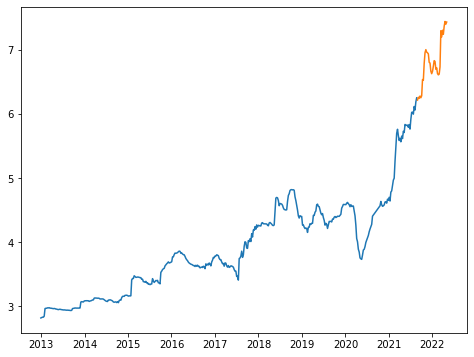

In [36]:
plt.figure(figsize=(8,6))
plt.plot(train_set.index, train_set)
plt.plot(test_set.index, test_set)
plt.show()

In [15]:
from pmdarima.arima import auto_arima

model = auto_arima(train_set)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  452
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 720.112
Date:                Thu, 23 Jun 2022   AIC                          -1432.224
Time:                        22:19:34   BIC                          -1415.778
Sample:                             0   HQIC                         -1425.743
                                - 452                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0077      0.004      1.962      0.050    9.18e-06       0.015
ma.L1          0.1562      0.031      4.967      0.000       0.095       0.218
ma.L2          0.2618      0.035      7.473      0.000       0.193       0.331
sigma2         0.0024   8.44e-05     28.456      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1661.69
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               3.49   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

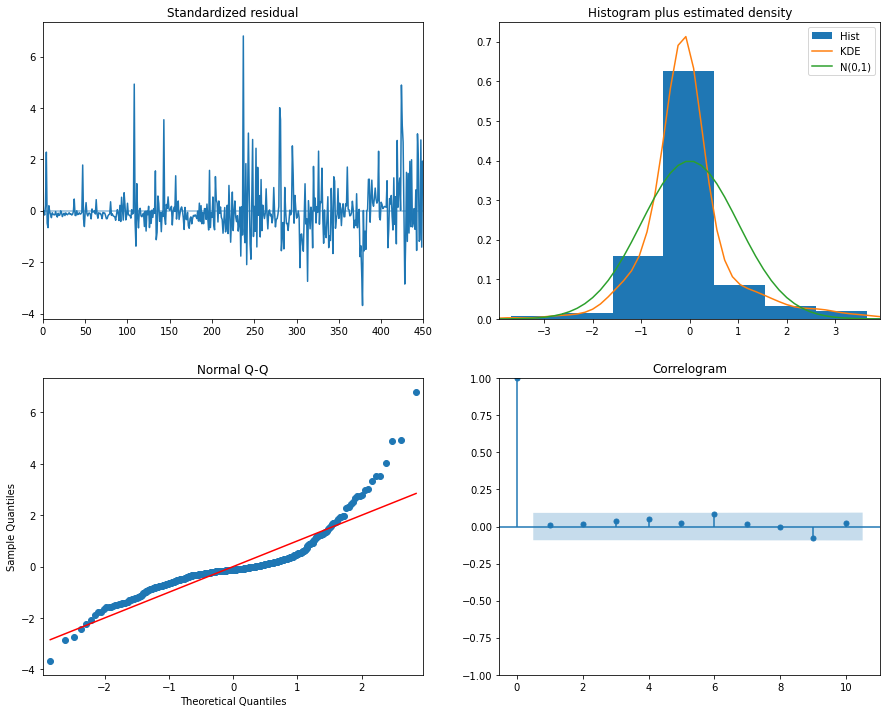

In [27]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

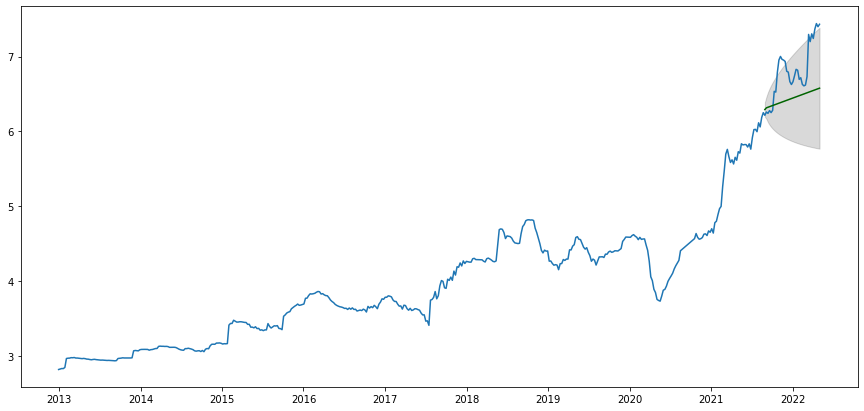

In [32]:
def forecast(model, freq):
  predicted, confint = model.predict(n_periods=test_size, return_conf_int=True)
  start_date = test_set.index.min()
  end_date = test_set.index.max()  

  date_range = create_date_range(start_date, end_date, freq)

  fitted_series = pd.Series(predicted, index=date_range)
  lower_series = pd.Series(confint[:, 0], index=date_range)
  upper_series = pd.Series(confint[:, 1], index=date_range)


    # Plot
  plt.figure(figsize=(15,7))
  plt.plot(data, color='#1f76b4')
  plt.plot(fitted_series, color='darkgreen')
  plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

forecast(model=model, freq=freq)

In [83]:
from statsmodels.tsa.arima.model import ARIMA
 
arima = ARIMA(train_set, order=(0,1,2)).fit()

In [88]:
arima_result = arima.forecast(steps=test_size)

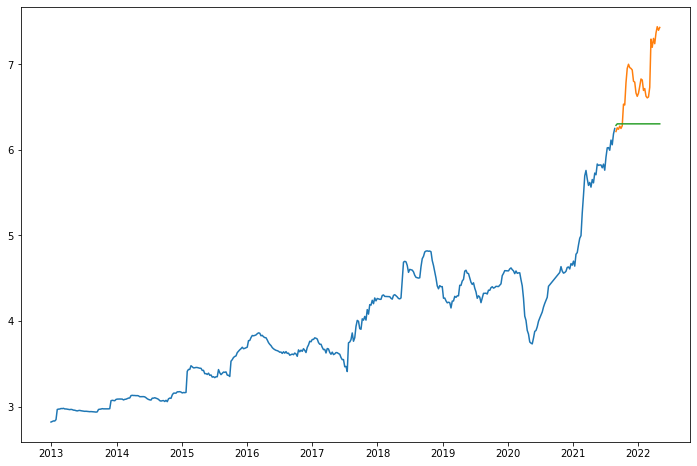

In [89]:
plt.figure(figsize=(12,8))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(arima_result)
plt.show()